In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import glob, sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import *
from plotting_utils import *
from lineplots import plotsd
from stabilizer_utils import *
from recalibration_utils import *
from session_utils import *

import hmm_utils
from hmm import HMMRecalibration
import stabilizer_utils

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


min_nblocks    = 2
participant    = 'T5'


FILE_DIR       = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/' + participant + '/'
fig_path       = '/home/users/ghwilson/projects/nonstationarities/figures/'
filelist       = glob.glob(FILE_DIR + 'historical/*')
filelist.extend(glob.glob(FILE_DIR + 'new/*'))

block_constraints = getBlockConstraints(FILE_DIR)
files             = get_Sessions(filelist, min_nblocks,  block_constraints = block_constraints)

### train linear regression on day 0, get baseline performance measure


In [2]:

# general settings:
ref_idx    = 1
new_idx    = 5
train_size = 0.67
sigma      = 2
task       = None

# recalibration settings:
hmm_cfg  = {'gridSize' : 20, 'stayProb' : 0.999, 'vmKappa' : 2, 'inflection' : 70, 'exp' : 0.5}
stab_cfg = {'model_type' : 'FactorAnalysis', 'n_components' : 6, 'B' : 160, 'thresh' : 0.01}

In [3]:
# Get initial day performance and decoder:
fields     = ['TX', 'cursorPos', 'targetPos']
stab_data  = {}


ref_file    = files[ref_idx]
day0        = DataStruct(ref_file, alignScreens = True, causal_filter = sigma)
session_dat = getTrainTest(day0, train_size = train_size, task = task, blocks = block_constraints[ref_file], 
                           fields = fields, returnFlattened = True)

train_y     = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
test_y      = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])
train_x, test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'], method = 'blockwise', concatenate = True)

# fit a regular regression model
ref_decoder = LinearRegression(fit_intercept = False, normalize = False).fit(train_x, train_y)
ref_score   = ref_decoder.score(test_x, test_y)

# fit a factor-analysis based model
stab = stabilizer_utils.Stabilizer(model_type = stab_cfg['model_type'], n_components = stab_cfg['n_components'])
stab.fit_ref(train_x)
stab_data['ref_latents'] = stab.ref_model.transform(test_x)
stab_data['ref_y']       = test_y

latent_decoder = LinearRegression(fit_intercept = False, normalize = False).fit(stab.ref_model.transform(train_x), train_y)
latent_score   = latent_decoder.score(stab.ref_model.transform(test_x), test_y)

print('Performance on reference day: R^2 = ', ref_score)
print('Performance on reference day w/ latent decoder: R^2 = ', latent_score)

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Performance on reference day: R^2 =  0.4285319325532501
Performance on reference day w/ latent decoder: R^2 =  0.3786094580292838


In [4]:
# now test on new day

file        = files[new_idx]
new_dat     = DataStruct(file, alignScreens = True, causal_filter = sigma)
blocks      = block_constraints[file]
session_dat = getTrainTest(new_dat, train_size = train_size, task = task, blocks = blocks, fields = fields, returnFlattened = True)

train_y         = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
test_y          = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])
train_x, test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'], method = 'blockwise', concatenate = True)
cursorPos       = np.concatenate(session_dat['train_cursorPos'])

# HMM fitting:
nStates         = hmm_cfg['gridSize']**2
stateTrans      = np.eye(nStates) * hmm_cfg['stayProb'] #Define the state transition matrix, which assumes uniform transition probability of transitioning to new state
targLocs        = hmm_utils.get_DiscreteTargetGrid(new_dat, gridSize = hmm_cfg['gridSize'], task = task)

for x in range(nStates):
    idx                = np.setdiff1d(np.arange(nStates), x)
    stateTrans[x, idx] = (1-hmm_cfg['stayProb'])/(nStates-1)
    
pStateStart = np.zeros((nStates,1)) + (1/nStates)
adjustKappa = lambda dist : 1 / (1 + np.exp(-1 * (dist - hmm_cfg['inflection']) * hmm_cfg['exp']))

hmm         = HMMRecalibration(stateTrans, targLocs, pStateStart, hmm_cfg['vmKappa'], adjustKappa)
rawDecTraj  = ref_decoder.predict(train_x)

viterbi_seq, viterbi_prob = hmm.viterbi_search(rawDecTraj, cursorPos)
targStates, pTargState    = hmm.decode(rawDecTraj, cursorPos)
maxProb                   = np.max(targStates, axis = 0)  # get P(H_i | O_1, ...., O_n)
inferredTargLoc           = targLocs[viterbi_seq.astype(int), :] 

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
stab.fit_new(train_x, B = stab_cfg['B'], thresh = stab_cfg['thresh'])

stab_data['new_latents'] = stab.ref_model.transform(test_x)
stab_data['new_y']       = test_y

stab_data['stabilized_latents'] = stab.transform(test_x)
stab_data['stabilized_y']       = test_y

array([[-1.06333635, -0.79259334, -0.09009104],
       [-1.0112273 , -0.86620889, -0.10036929],
       [-0.91584769, -0.77809826, -0.07713074],
       ...,
       [ 0.00120188,  0.29363425,  0.65274956],
       [-0.14759861,  0.13261505,  0.74152976],
       [-0.27246695, -0.04182484,  0.8942446 ]])

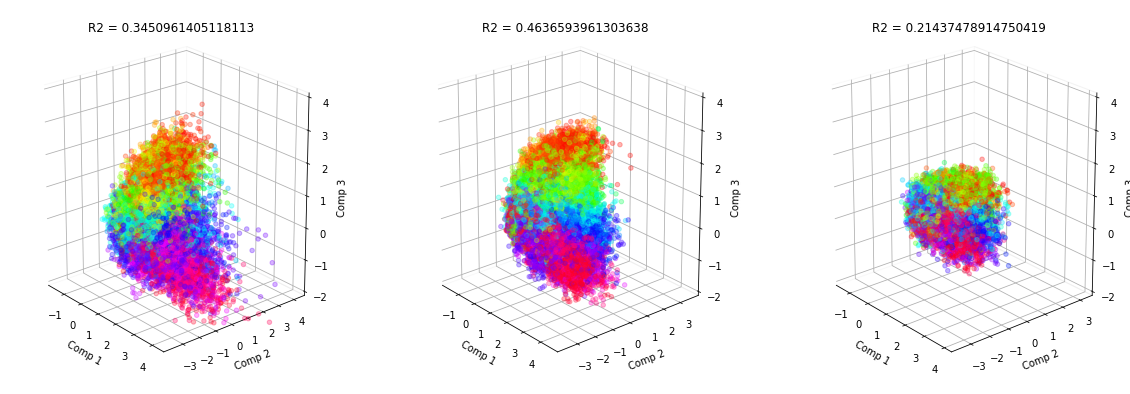

In [49]:
import CosineTuning
from mpl_toolkits import mplot3d

figSize(7, 20)

#stab_data['ref_latents']

for i, field in enumerate(['ref', 'stabilized', 'new']):
    displacements = stab_data[field + '_y']
    latents       = stab_data[field + '_latents']
    #latents = firingrate.gaussian_filter1d(latents, axis = 0, sigma = 2, causal=True)
    #displacements = firingrate.gaussian_filter1d(displacements, axis = 0, sigma = 2, causal=True)

    time_idxs = np.where(np.linalg.norm(displacements, axis = 1) > 200)[0]#[1000:7000]
    angles    = CosineTuning.getAngles(displacements[time_idxs])
    coords    = latents[time_idxs, :3]
    
    ax     = plt.subplot(1, 3, i + 1, projection='3d')
    ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2], s= 20,
                 c = angles, cmap = 'hsv', alpha = 0.3, rasterized = True)
    ax.view_init(20, 320)  #320

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_zlim([-2, 4])
    
    plt.xlabel('Comp 1')
    plt.ylabel('Comp 2')
    ax.set_zlabel('Comp 3')
    
    r2 = latent_decoder.score(latents, displacements)
    plt.title('R2 = {}'.format(r2))

plt.savefig(fig_path + 'stabilizer/T5example', format = 'pdf')
plt.show()

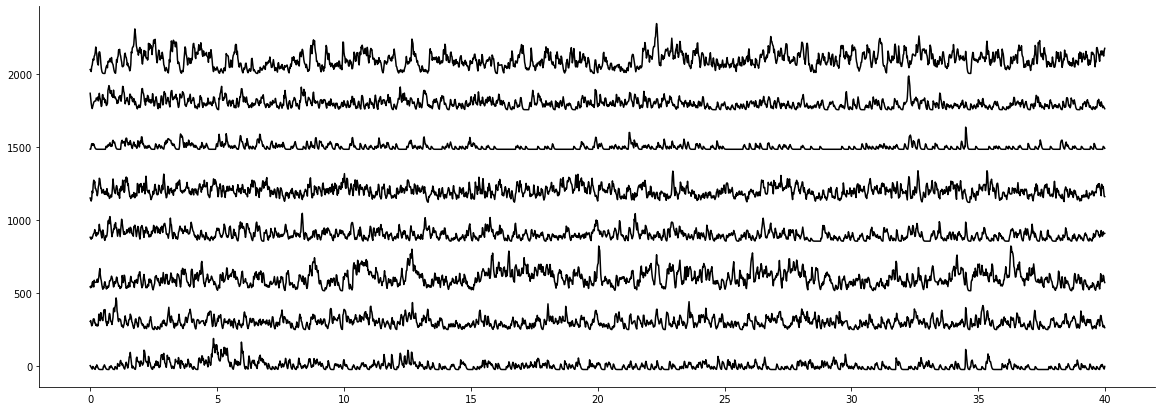

In [7]:
n_channels = 8
window     = np.arange(2000)
_ = plt.plot(window * 0.02, train_x[window, :n_channels] + np.arange(n_channels) * 300, c = 'k')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(fig_path + 'HMM/T5example_firingrates', format = 'pdf')
plt.show()

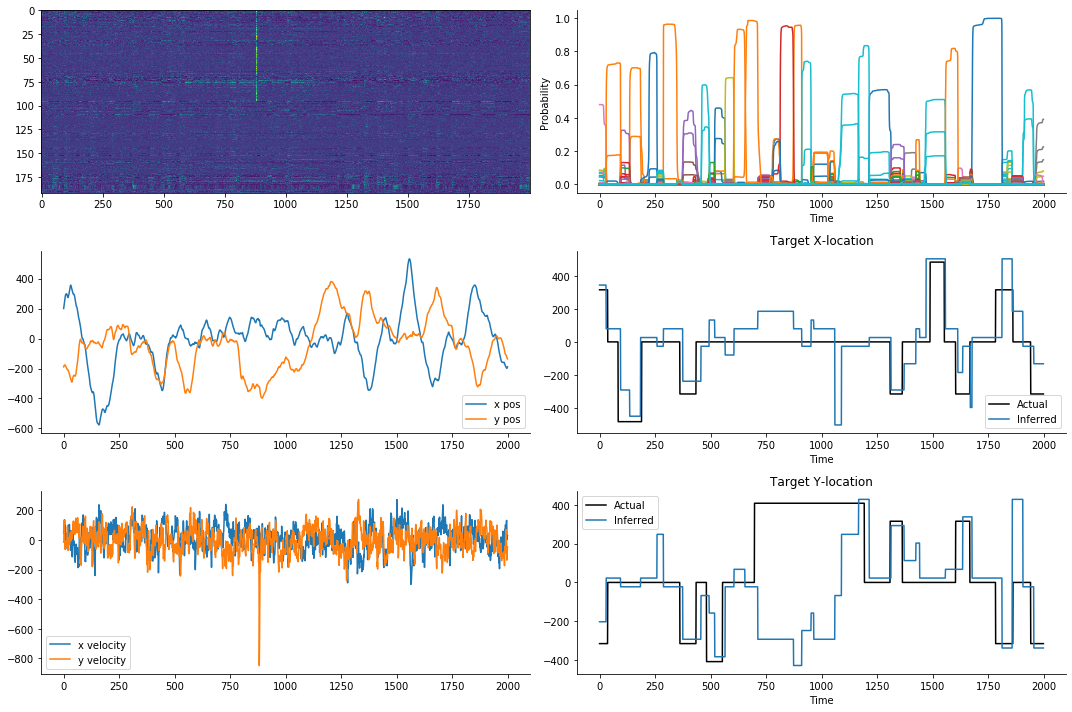

In [8]:
figSize(10, 15)

window = np.arange(1000, 3000) + 2000


plt.subplot(3, 2, 1)
plt.imshow(train_x[window, :].T, aspect = 'auto')

plt.subplot(3, 2, 3)
_ = plt.plot(cursorPos[window, 0], label = 'x pos')
_ = plt.plot(cursorPos[window, 1], label = 'y pos')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()

plt.subplot(3,2, 5)
_ = plt.plot(rawDecTraj[window, 0], label = 'x velocity')
_ = plt.plot(rawDecTraj[window, 1], label = 'y velocity')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()


plt.subplot(3, 2, 2)
_ = plt.plot(targStates[:, window].T)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Time')
plt.ylabel('Probability')

titles = ['Target X-location', 'Target Y-location']
for i in range(2):
    plt.subplot(3, 2, (i * 2) + 4)
    plt.plot((train_y + cursorPos)[window, i], label = 'Actual', c = 'k')
    plt.plot(inferredTargLoc[window, i], label = 'Inferred', zorder = 10)
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel('Time')
    plt.legend()
    plt.title(titles[i])

plt.tight_layout()
plt.show()

#plt.savefig(fig_path + 'HMM/T5example_cursorandneural', format = 'pdf')

Now test across a series of sessions

In [13]:
import copy

# General parameters: 
start_idx     = 1
n_sessions    = 13
train_size    = 0.5
task          = None
sigma         = 2
probThreshold = 'probWeighted'


# ---------------------------------------------------
scores  = np.zeros((6, n_sessions + 1)) 
dates   = np.empty(n_sessions + 1, dtype = object)
# rows are 0 - no recalibration; 1 - mean recalibration; 
# 2 - full recalibration; 3 - stabilizer recalibration; 
# 4 - stabilizer (chained); 5- HMM recalibration (each session)
fields  = ['TX', 'cursorPos', 'targetPos']


# Initialize first day
day0         = DataStruct(files[start_idx], alignScreens = True, causal_filter = sigma)
session_dat  = getTrainTest(day0, train_size = train_size, task = task, blocks = block_constraints[files[start_idx]],
                            fields = fields, returnFlattened = True)

train_y         = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
test_y          = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])
train_x, test_x = get_BlockwiseMeanSubtracted(session_dat['train_TX'], session_dat['test_TX'], concatenate = True)
ref_means       = np.concatenate(session_dat['train_TX']).mean(axis = 0)

ref_decoder   = LinearRegression(fit_intercept = False, normalize = False).fit(train_x, train_y)
scores[:, 0]  = ref_decoder.score(test_x, test_y)
dates[0]      = day0.date

stab = stabilizer_utils.Stabilizer(model_type = stab_cfg['model_type'], n_components = stab_cfg['n_components'])
stab.fit_ref(train_x)
stab_daisychained = copy.deepcopy(stab)


latent_decoder = LinearRegression(fit_intercept = False, normalize = False).fit(stab.ref_model.transform(train_x), train_y)
scores[3, 0]   = latent_decoder.score(stab.ref_model.transform(test_x), test_y)

models        = list()
hmm_new_ref   = deepcopy(ref_decoder)
for i, file_idx in enumerate(range(start_idx, start_idx + n_sessions)):
    file       = files[file_idx]
    new_dat    = DataStruct(file, alignScreens = True, causal_filter = sigma)
    dates[i+1] = new_dat.date
    
    session_dat       = getTrainTest(new_dat, train_size = train_size, task = task, blocks = block_constraints[file], fields = fields, returnFlattened = True)
    train_y           = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y            = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])
    train_x, test_x   = subtractMeans(session_dat['train_TX'], session_dat['test_TX'], 
                                      method = 'blockwise', concatenate = True)
    test_x_stalemeans = np.concatenate(session_dat['test_TX']) - ref_means
    cursorPos         = np.concatenate(session_dat['train_cursorPos'])
    
    stab.fit_new(train_x, B = stab_cfg['B'], thresh = stab_cfg['thresh'])
    stab_daisychained.fit_new(train_x, B = stab_cfg['B'], thresh = stab_cfg['thresh'], daisy_chain = True)
    
    test_latent              = stab.transform(test_x)
    test_latent_daisychained = stab_daisychained.transform(test_x)
    hmm_new_ref              = hmm.recalibrate(hmm_new_ref, [train_x], [cursorPos], probThreshold = probThreshold)

    scores[0, i+1] = ref_decoder.score(test_x_stalemeans, test_y)                                    # no recalibration
    scores[1, i+1] = ref_decoder.score(test_x, test_y)                                               # mean recalibration
    scores[2, i+1] = LinearRegression(normalize = False).fit(train_x, train_y).score(test_x, test_y) # full recalibration
    
    scores[3, i+1] = latent_decoder.score(test_latent, test_y)
    scores[4, i+1] = latent_decoder.score(test_latent_daisychained, test_y)
    scores[5, i+1] = hmm_new_ref.score(test_x, test_y)
   
    print(new_dat.date, ' finished')

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


2016.09.28  finished
2016.10.03  finished
2016.10.05  finished
2016.10.07  finished
2016.10.10  finished
2016.10.12  finished
2016.10.13  finished
2016.10.17  finished
2016.10.19  finished
2016.10.24  finished
2016.10.26  finished
2016.10.31  finished
2016.12.06  finished


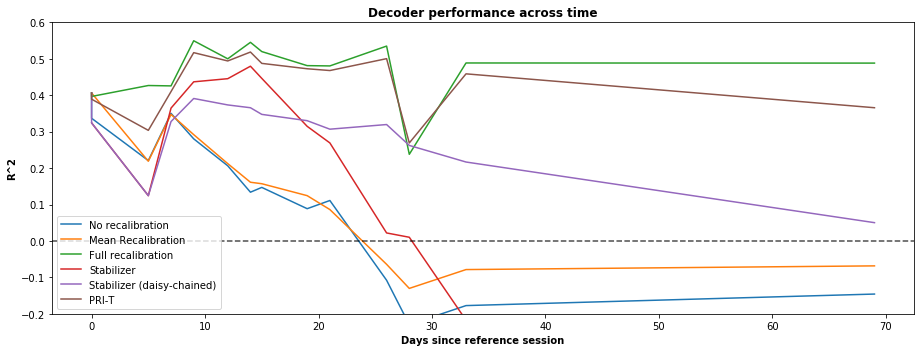

In [15]:
from preprocess import daysBetween
days = [daysBetween(dates[0], dates[i]) for i in range(len(dates))]


figSize(5, 25)

plt.subplot(1, 2, 1)
labels = ['No recalibration', 'Mean Recalibration', 'Full recalibration', 'Stabilizer', 
          'Stabilizer (daisy-chained)', 'PRI-T']
for i in range(6):
    plt.plot(days, scores[i, :].T, label = labels[i])

plt.ylim([-0.2, 0.6]) 
plt.xlabel('Days since reference session', fontweight = 'bold')
plt.ylabel('R^2', fontweight = 'bold')
plt.axhline(0, color = 'k', linestyle = '--', alpha  = 0.7)
plt.title('Decoder performance across time', fontweight = 'bold')
plt.legend()

plt.tight_layout()
plt.savefig(fig_path + 'HMM/T5example_HMM_and_stab_stretch', format = 'pdf')
plt.show()